In [ ]:
!pip install mxnet-cu101
!pip install gluonnlp pandas tqdm
!pip install sentencepiece==0.1.85
!pip install transformers==2.1.1
!pip install torch==1.3.1

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-8qpbcadc
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-8qpbcadc
  Created wheel for kobert: filename=kobert-0.1.1-cp36-none-any.whl size=12871 sha256=98b7119158dfe11702b3c0c770ff66ca93ec47180471e3366afa62edabc99bf1
  Stored in directory: /tmp/pip-ephem-wheel-cache-wm3_r9zz/wheels/a2/b0/41/435ee4e918f91918be41529283c5ff86cd010f02e7525aecf3
Successfully built kobert


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/GPT/07_02_gpt/')

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from kobert.utils import get_tokenizer
from kogpt2.pytorch_kogpt2 import get_pytorch_kogpt2_model

from transformers import AdamW
from transformers.optimization import WarmupLinearSchedule
import matplotlib.pyplot as plt

device = torch.device("cuda")
print(device)
save_path = './checkpoint/'
gpt2model, vocab = get_pytorch_kogpt2_model()

dataset_train = nlp.data.TSVDataset("./nsmc/ratings_train.txt", field_indices=[1,2], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset("./nsmc/ratings_test.txt", field_indices=[1,2], num_discard_samples=1)

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

class GPT2Dataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, gpt2_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            gpt2_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

def plot_graphs(history, string):
    plt.plot(history)
    plt.ylabel(string)
    plt.xlabel('epoch')
    plt.legend([string, 'epoch'])
    plt.title('NSMC FINE-TUNING {0}'.format(string.upper()))
    plt.savefig('{0}_loss.jpg'.format(string))
    plt.show()

max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

data_train = GPT2Dataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = GPT2Dataset(dataset_test, 0, 1, tok, max_len, True, False)

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

class GPT2Classifier(nn.Module):
    def __init__(self,
                 gpt2,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(GPT2Classifier, self).__init__()
        self.gpt2 = gpt2
        self.dr_rate = dr_rate
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def forward(self, token_ids, segment_ids):
        _, pooler = self.gpt2(input_ids = token_ids, token_type_ids=segment_ids.long())
        pool = pooler[:,-1]

        if self.dr_rate:
            out = self.dropout(pool)
        return self.classifier(out)

model = GPT2Classifier(gpt2model,  dr_rate=0.5).to(device)

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_step, t_total=t_total)

def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

count = 0
result_l = []
result_a = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    print('Transfer Learning Start')
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        result_l.append(loss.data.cpu().numpy())
        result_a.append(train_acc / (batch_id + 1))

        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
        #################################################################
        count += 1

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    with open('checkpoint/checkpoint_{}.model'.format(str(e + 1).zfill(2)), 'wb') as f:
        torch.save(model.state_dict(), f)
    model.eval()

    test_a = []
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, segment_ids)
        test_acc += calc_accuracy(out, label)
        test_a.append(train_acc / (batch_id + 1))
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

cuda
using cached model
using cached model
using cached model
Transfer Learning Start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


epoch 1 batch id 1 loss 0.6896632313728333 train acc 0.59375
epoch 1 batch id 201 loss 0.6865984797477722 train acc 0.5076181592039801
epoch 1 batch id 401 loss 0.7114626169204712 train acc 0.510286783042394
epoch 1 batch id 601 loss 0.7044362425804138 train acc 0.5209806572379367
epoch 1 batch id 801 loss 0.6278400421142578 train acc 0.5490012484394506
epoch 1 batch id 1001 loss 0.48337259888648987 train acc 0.5785308441558441
epoch 1 batch id 1201 loss 0.6183149814605713 train acc 0.6059013322231473
epoch 1 batch id 1401 loss 0.53080815076828 train acc 0.6293272662384012
epoch 1 batch id 1601 loss 0.497279554605484 train acc 0.6493207370393504
epoch 1 batch id 1801 loss 0.45667019486427307 train acc 0.667285535813437
epoch 1 batch id 2001 loss 0.4266849756240845 train acc 0.6833302098950524
epoch 1 batch id 2201 loss 0.3134597837924957 train acc 0.6974244661517492

epoch 1 train acc 0.7064668657565415


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 1 test acc 0.857696611253197
Transfer Learning Start


epoch 2 batch id 1 loss 0.6286032199859619 train acc 0.734375
epoch 2 batch id 201 loss 0.26634833216667175 train acc 0.8524564676616916
epoch 2 batch id 401 loss 0.3795333504676819 train acc 0.8527899002493765
epoch 2 batch id 601 loss 0.40167421102523804 train acc 0.8566191763727121
epoch 2 batch id 801 loss 0.39227354526519775 train acc 0.8590238764044944
epoch 2 batch id 1001 loss 0.3162016272544861 train acc 0.8599837662337663
epoch 2 batch id 1201 loss 0.28349563479423523 train acc 0.8613264987510408
epoch 2 batch id 1401 loss 0.2671639621257782 train acc 0.8624977694503926
epoch 2 batch id 1601 loss 0.2907755374908447 train acc 0.8637863054341037
epoch 2 batch id 1801 loss 0.30546998977661133 train acc 0.8646498473070516
epoch 2 batch id 2001 loss 0.30863305926322937 train acc 0.8663793103448276
epoch 2 batch id 2201 loss 0.264946311712265 train acc 0.8679861426624261

epoch 2 train acc 0.8695094745449374



epoch 2 test acc 0.8833320012787724
Transfer Learning Start


epoch 3 batch id 1 loss 0.5267064571380615 train acc 0.828125
epoch 3 batch id 201 loss 0.17324914038181305 train acc 0.8894589552238806
epoch 3 batch id 401 loss 0.2260160893201828 train acc 0.8902743142144638
epoch 3 batch id 601 loss 0.34214290976524353 train acc 0.8920809068219634
epoch 3 batch id 801 loss 0.3149663507938385 train acc 0.8928292759051186
epoch 3 batch id 1001 loss 0.31557247042655945 train acc 0.8923888611388612
epoch 3 batch id 1201 loss 0.22074037790298462 train acc 0.892407368859284
epoch 3 batch id 1401 loss 0.21172423660755157 train acc 0.892543272662384
epoch 3 batch id 1601 loss 0.22689825296401978 train acc 0.8935235790131169
epoch 3 batch id 1801 loss 0.23215818405151367 train acc 0.8938436979455858
epoch 3 batch id 2001 loss 0.2413327395915985 train acc 0.8946932783608196
epoch 3 batch id 2201 loss 0.216008260846138 train acc 0.8956156292594275

epoch 3 train acc 0.8965132608077361



epoch 3 test acc 0.8899056905370843
Transfer Learning Start


epoch 4 batch id 1 loss 0.4614434242248535 train acc 0.84375
epoch 4 batch id 201 loss 0.1464034616947174 train acc 0.9098258706467661
epoch 4 batch id 401 loss 0.16263723373413086 train acc 0.9108478802992519
epoch 4 batch id 601 loss 0.30001023411750793 train acc 0.9111896838602329
epoch 4 batch id 801 loss 0.30837705731391907 train acc 0.9114778401997503
epoch 4 batch id 1001 loss 0.2949066460132599 train acc 0.9117445054945055
epoch 4 batch id 1201 loss 0.1798364371061325 train acc 0.9118182764363031
epoch 4 batch id 1401 loss 0.1589297205209732 train acc 0.9119602069950036
epoch 4 batch id 1601 loss 0.22848060727119446 train acc 0.9122423485321673
epoch 4 batch id 1801 loss 0.174230694770813 train acc 0.9124357995558023
epoch 4 batch id 2001 loss 0.23489566147327423 train acc 0.912957583708146
epoch 4 batch id 2201 loss 0.12079976499080658 train acc 0.9135975124943208

epoch 4 train acc 0.9143780218998863



epoch 4 test acc 0.8904451726342711
Transfer Learning Start


epoch 5 batch id 1 loss 0.49303025007247925 train acc 0.828125
epoch 5 batch id 201 loss 0.12135051935911179 train acc 0.9214863184079602
epoch 5 batch id 401 loss 0.1378455013036728 train acc 0.9246415211970075
epoch 5 batch id 601 loss 0.2742954194545746 train acc 0.9247868136439268
epoch 5 batch id 801 loss 0.24972335994243622 train acc 0.9250936329588015
epoch 5 batch id 1001 loss 0.26424941420555115 train acc 0.9256368631368631
epoch 5 batch id 1201 loss 0.14038382470607758 train acc 0.925634887593672
epoch 5 batch id 1401 loss 0.19593030214309692 train acc 0.9254104211277658
epoch 5 batch id 1601 loss 0.14814436435699463 train acc 0.9255055434103685
epoch 5 batch id 1801 loss 0.13860566914081573 train acc 0.9258658384230983
epoch 5 batch id 2001 loss 0.16753850877285004 train acc 0.9263415167416292
epoch 5 batch id 2201 loss 0.09888330101966858 train acc 0.9268017378464335

epoch 5 train acc 0.9276032778725826



epoch 5 test acc 0.8923833120204604
Transfer Learning Start


epoch 6 batch id 1 loss 0.5498617887496948 train acc 0.8125
epoch 6 batch id 201 loss 0.12633642554283142 train acc 0.9373445273631841
epoch 6 batch id 401 loss 0.09950410574674606 train acc 0.9365648379052369
epoch 6 batch id 601 loss 0.24232929944992065 train acc 0.9370840266222962
epoch 6 batch id 801 loss 0.21198314428329468 train acc 0.9369343008739076
epoch 6 batch id 1001 loss 0.3221667408943176 train acc 0.9370161088911089
epoch 6 batch id 1201 loss 0.1076408326625824 train acc 0.9370966902581183
epoch 6 batch id 1401 loss 0.1399107575416565 train acc 0.9370985010706638
epoch 6 batch id 1601 loss 0.14767861366271973 train acc 0.9373340880699563
epoch 6 batch id 1801 loss 0.10936927795410156 train acc 0.9375694058856191
epoch 6 batch id 2001 loss 0.22770772874355316 train acc 0.9379763243378311
epoch 6 batch id 2201 loss 0.08882717788219452 train acc 0.9381815084052704

epoch 6 train acc 0.9388309691410693



epoch 6 test acc 0.8925431585677749
Transfer Learning Start


epoch 7 batch id 1 loss 0.5379405617713928 train acc 0.84375
epoch 7 batch id 201 loss 0.1370486170053482 train acc 0.9424751243781094
epoch 7 batch id 401 loss 0.07701720297336578 train acc 0.9452540523690773
epoch 7 batch id 601 loss 0.23250551521778107 train acc 0.9453254991680532
epoch 7 batch id 801 loss 0.1416836977005005 train acc 0.9456733770287141
epoch 7 batch id 1001 loss 0.21066400408744812 train acc 0.9456949300699301
epoch 7 batch id 1201 loss 0.08837194740772247 train acc 0.9458524146544546
epoch 7 batch id 1401 loss 0.12815211713314056 train acc 0.9459203247680228
epoch 7 batch id 1601 loss 0.06056961417198181 train acc 0.9462640537164272
epoch 7 batch id 1801 loss 0.143549844622612 train acc 0.9464707107162688
epoch 7 batch id 2001 loss 0.19702152907848358 train acc 0.9466360569715142
epoch 7 batch id 2201 loss 0.053550008684396744 train acc 0.9468778396183553

epoch 7 train acc 0.9473567263936291



epoch 7 test acc 0.8926031010230179
Transfer Learning Start


epoch 8 batch id 1 loss 0.6247132420539856 train acc 0.796875
epoch 8 batch id 201 loss 0.10391588509082794 train acc 0.9497823383084577
epoch 8 batch id 401 loss 0.051500577479600906 train acc 0.952540523690773
epoch 8 batch id 601 loss 0.29707998037338257 train acc 0.9529950083194676
epoch 8 batch id 801 loss 0.0980878472328186 train acc 0.9528909176029963
epoch 8 batch id 1001 loss 0.18797728419303894 train acc 0.9527347652347652
epoch 8 batch id 1201 loss 0.05672287568449974 train acc 0.952929850124896
epoch 8 batch id 1401 loss 0.18458184599876404 train acc 0.9530469307637401
epoch 8 batch id 1601 loss 0.0485389418900013 train acc 0.9535446595877577
epoch 8 batch id 1801 loss 0.18127578496932983 train acc 0.9538711132704053
epoch 8 batch id 2001 loss 0.13504162430763245 train acc 0.9542962893553223
epoch 8 batch id 2201 loss 0.10532242059707642 train acc 0.9546938891412994

epoch 8 train acc 0.9550070214732651



epoch 8 test acc 0.8917039641943734
Transfer Learning Start


epoch 9 batch id 1 loss 0.4509359896183014 train acc 0.875
epoch 9 batch id 201 loss 0.05144333094358444 train acc 0.9549129353233831
epoch 9 batch id 401 loss 0.05915312469005585 train acc 0.9576059850374065
epoch 9 batch id 601 loss 0.18906505405902863 train acc 0.9580906821963394
epoch 9 batch id 801 loss 0.23306545615196228 train acc 0.9584893882646691
epoch 9 batch id 1001 loss 0.17455166578292847 train acc 0.9590877872127872
epoch 9 batch id 1201 loss 0.06620313227176666 train acc 0.9592136761032473
epoch 9 batch id 1401 loss 0.190967857837677 train acc 0.9587125267665952
epoch 9 batch id 1601 loss 0.035348549485206604 train acc 0.9589514366021237
epoch 9 batch id 1801 loss 0.11189397424459457 train acc 0.9589117157134925
epoch 9 batch id 2001 loss 0.19441990554332733 train acc 0.9591688530734632
epoch 9 batch id 2201 loss 0.03984861448407173 train acc 0.9593153680145389

epoch 9 train acc 0.959679856370876



epoch 9 test acc 0.891863810741688
Transfer Learning Start


epoch 10 batch id 1 loss 0.4312610328197479 train acc 0.875
epoch 10 batch id 201 loss 0.08232895284891129 train acc 0.9607431592039801
epoch 10 batch id 401 loss 0.04651842266321182 train acc 0.9631390274314214
epoch 10 batch id 601 loss 0.15976068377494812 train acc 0.9631343594009983
epoch 10 batch id 801 loss 0.20981112122535706 train acc 0.9631125156054932
epoch 10 batch id 1001 loss 0.19026535749435425 train acc 0.9629745254745254
epoch 10 batch id 1201 loss 0.0585268959403038 train acc 0.9628694837635304
epoch 10 batch id 1401 loss 0.13469484448432922 train acc 0.9626829050678087
epoch 10 batch id 1601 loss 0.05665723979473114 train acc 0.9625819800124922
epoch 10 batch id 1801 loss 0.05298319086432457 train acc 0.9627290394225431
epoch 10 batch id 2001 loss 0.13956399261951447 train acc 0.9628310844577711
epoch 10 batch id 2201 loss 0.033018965274095535 train acc 0.9629784756928669

epoch 10 train acc 0.9632883603526734



epoch 10 test acc 0.8909247122762148


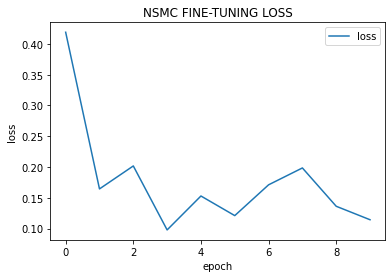

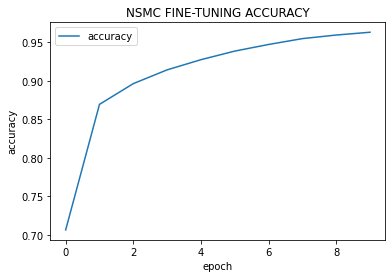

In [ ]:
l = []
a = []
for i in range(1, 11):
  l.append(result_l[2343*i])
  a.append(result_a[2343*i])

plot_graphs(l, 'loss')
plot_graphs(a, 'accuracy')